# Data

| Feature Name               | Description                           |
|----------------------------|-------------------------------------|
| person_age                 | Age                                 |
| person_income              | Annual Income                       |
| person_home_ownership      | Home ownership                      |
| person_emp_length          | Employment length (in years)        |
| loan_intent                | Loan intent                        |
| loan_grade                 | Loan grade                        |
| loan_amnt                 | Loan amount                       |
| loan_int_rate              | Interest rate                     |
| loan_status                | Loan status (0 is non default, 1 is default) |
| loan_percent_income        | Percent income                    |
| cb_person_default_on_file  | Historical default                 |
| cb_preson_cred_hist_length | Credit history length              |


# Imports


In [ ]:
!pip install xgboost 

In [34]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import joblib

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model,Sequential
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, CSVLogger
from sklearn.metrics import f1_score
from sklearn.calibration import calibration_curve


In [30]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

In [34]:
original_data=pd.read_csv('credit_risk_dataset.csv')

In [35]:
print(original_data.shape)
32581*0.04

(32581, 12)


1303.24

# Transformations

## removing outliers

In [36]:
mask = (
    (original_data['person_age'] > 85) |
    (original_data['person_income'] > 200000) |
    (original_data['person_emp_length'] > 18) |
    (original_data['loan_amnt'] > 28000)
)

In [37]:
print("Number of rows to be removed:", mask.sum())
print("Original shape:", original_data.shape)
print("Filtered shape:", original_data[~mask].shape)
data=original_data[~mask]

Number of rows to be removed: 941
Original shape: (32581, 12)
Filtered shape: (31640, 12)


## one hot encoding

In [38]:
# Create one-hot encoded columns for person_home_ownership
home_ownership_encoded = pd.get_dummies(data['person_home_ownership'], prefix='home_ownership',  dtype=int)

# Create one-hot encoded columns for loan_intent  
loan_intent_encoded = pd.get_dummies(data['loan_intent'], prefix='loan_intent',  dtype=int)

# Concatenate the encoded columns with the original data
data_encoded = pd.concat([data, home_ownership_encoded, loan_intent_encoded], axis=1)

# Drop the original categorical columns
data_encoded = data_encoded.drop(['person_home_ownership','home_ownership_OTHER', 'loan_intent', 'loan_intent_HOMEIMPROVEMENT'], axis=1)

data = data_encoded


## ordinal and binary transformation

In [39]:
# Binary transformation for cb_person_default_on_file
data['cb_person_default_on_file'] = (data['cb_person_default_on_file'] == 'Y').astype(int)

# Ordinal transformation for loan_grade (A=1, B=2, C=3, D=4, E=5, F=6, G=7)
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
data['loan_grade'] = data['loan_grade'].map(grade_mapping)


# Missing values

In [40]:
# Create a dataset without missing values(train dataset)
data_no_missing = data.dropna()

# Create a dataset with records that contain missing values(evaluate dataset)
data_with_missing = data[data.isnull().any(axis=1)]

# Print the shapes of both datasets
print("Dataset without missing values shape:", data_no_missing.shape)
print("Dataset with missing values shape:", data_with_missing.shape)

Dataset without missing values shape: (27794, 18)
Dataset with missing values shape: (3846, 18)


## Person_emp_lenght

In [41]:
X = data_no_missing.drop('person_emp_length', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, data_no_missing['person_emp_length'], test_size=0.2, random_state=22)

random forest

In [42]:
model = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=5)
scores = cross_validate(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, return_train_score=True)

print("Cross-validation scores:", -scores['test_score'])


Cross-validation scores: [2.8582728  2.88015891 2.82610133 2.84447219 2.85344361]


lgbmr 

In [43]:
model = lgb.LGBMRegressor(
    n_estimators=300,
    max_depth=5,
    random_state=42
)

# Cross-validation
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

mae_scores = -cv_results['test_score']
print("Cross-validation MAEs:", mae_scores)

Cross-validation MAEs: [2.8309246  2.85932654 2.7931482  2.81489645 2.79808165]


XGBR

In [44]:
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

# Cross-validation
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    return_train_score=True
)

# Convert to positive MAE
mae_scores = -cv_results['test_score']
print("Cross-validation MAEs:", mae_scores)


Cross-validation MAEs: [2.83263668 2.85904282 2.7876798  2.81434441 2.81092383]


In [45]:
print(data['person_emp_length'].mean())
2.8209/4.6*100

4.631039864733043


61.323913043478264

## loan_int_rate

In [46]:
X = data_no_missing.drop('loan_int_rate', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, data_no_missing['loan_int_rate'], test_size=0.2, random_state=22)

random forest

In [47]:
model = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=5)
scores = cross_validate(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, return_train_score=True)

print("Cross-validation scores:", -scores['test_score'])

Cross-validation scores: [0.78918762 0.78083667 0.79441693 0.77460732 0.78113161]


lgmr

In [48]:
model = lgb.LGBMRegressor(
    n_estimators=300,
    max_depth=5,
    random_state=22
)

# Cross-validation
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

mae_scores = -cv_results['test_score']
print("Cross-validation MAEs:", mae_scores)

Cross-validation MAEs: [0.79434935 0.78459249 0.79363331 0.77718244 0.78499525]


XGBR

In [49]:
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    random_state=22,
    verbosity=0
)

# Cross-validation
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    return_train_score=True
)

# Convert to positive MAE
mae_scores = -cv_results['test_score']
print("Cross-validation MAEs:", mae_scores)
print("Training scores:", -cv_results['train_score'])

Cross-validation MAEs: [0.79073387 0.78179577 0.79554029 0.78172074 0.78182814]
Training scores: [0.77046698 0.77276663 0.77069201 0.77515306 0.77380323]


In [50]:
# Fit on full training set
model.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", test_mae)

Test MAE: 0.7889745032236203


In [51]:
print(data['loan_int_rate'].mean())
0.78/10.990000 *100

10.981918358787963


7.097361237488626

In [52]:
model.save_model('xgb_model.json')

Our model’s average error is about 7% of the typical value

## Imputing Missing Values

In [53]:
model = xgb.XGBRegressor()
model.load_model('xgb_model.json')

missing_loan_int_rate = data[data['loan_int_rate'].isnull()]
X_missing = missing_loan_int_rate.drop('loan_int_rate', axis=1)
predicted_loan_int_rate = model.predict(X_missing)
    
# Fill missing values with predictions
data.loc[data['loan_int_rate'].isnull(), 'loan_int_rate'] = predicted_loan_int_rate


In [54]:
# Impute missing person_emp_length values with the mean
data['person_emp_length'].fillna(data['person_emp_length'].mean(), inplace=True)

C:\Users\david\AppData\Local\Temp\ipykernel_7232\3600513039.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['person_emp_length'].fillna(data['person_emp_length'].mean(), inplace=True)


# Correlation

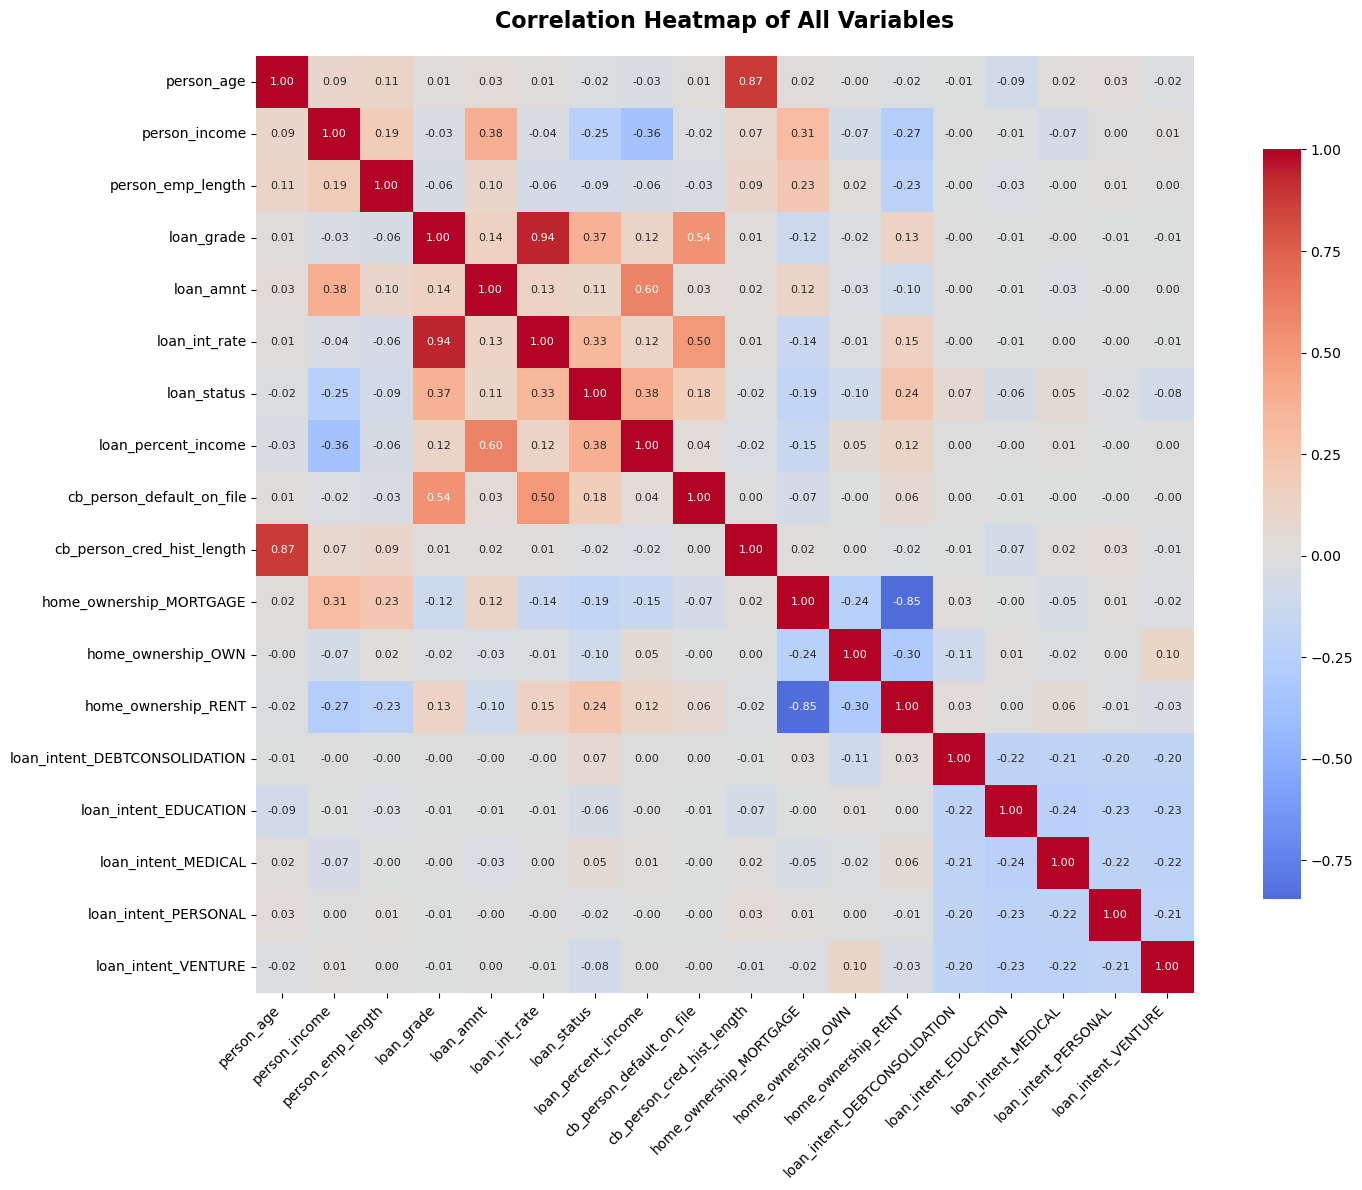

Strongest correlations with loan_status:
loan_status                  1.000000
loan_percent_income          0.380056
loan_grade                   0.372011
loan_int_rate                0.332541
person_income                0.245492
home_ownership_RENT          0.237762
home_ownership_MORTGAGE      0.188312
cb_person_default_on_file    0.178689
loan_amnt                    0.105096
home_ownership_OWN           0.100812
Name: loan_status, dtype: float64


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = data.corr()

# Create the heatmap
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={"shrink": 0.8},
    annot_kws={'size': 8}
)

plt.title('Correlation Heatmap of All Variables', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations with loan_status (target variable)
print("Strongest correlations with loan_status:")
loan_status_corr = correlation_matrix['loan_status'].abs().sort_values(ascending=False)
print(loan_status_corr.head(10))


Since we will be using tree-based models and deep learning, high linear correlation among features is not a major concern. Neural networks can capture non-linear relationships, and tree-based methods can inherently select the most relevant features.

# Final dataset

In [ ]:
#data.to_csv('final_data.csv', index=False)

In [4]:
data= pd.read_csv('final_data.csv')

# Splits

In [5]:
X = data.drop('loan_status', axis=1)
y=data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, shuffle=True, stratify=y)

# Models

## Assemble

In [59]:


# Define the individual models
rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=300, 
    max_depth=5
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=22,
    verbosity=-1
)

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    random_state=22,
    verbosity=0
)

# Create the ensemble with majority voting
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lgb', lgb_model),
        ('xgb', xgb_model)
    ],
    voting='hard'  # Use 'hard' for majority voting
)

# Cross-validation on ensemble
cv_results = cross_validate(
    ensemble_model,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    return_train_score=True
)

print("Ensemble Cross-validation F1 scores:", cv_results['test_score'])
print("Mean F1:", cv_results['test_score'].mean())
print("Std F1:", cv_results['test_score'].std())

Ensemble Cross-validation F1 scores: [0.81359533 0.81216649        nan 0.80021368 0.79506438]
Mean F1: nan
Std F1: nan


c:\Users\david\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\david\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\david\anaconda3\Lib\site-packages\sklearn\ensemble\_voting.py", line 366, in fit
    return super().fit(X

In [60]:
# Fit ensemble on full training set
ensemble_model.fit(X_train, y_train)

# Predict on test set
ensemble_predictions = ensemble_model.predict(X_test)

# Calculate metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

ensemble_f1 = f1_score(y_test, ensemble_predictions)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_recall = recall_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions)

print("Ensemble Test Results:")
print(f"F1 Score: {ensemble_f1:.4f}")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"Precision: {ensemble_precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, ensemble_predictions))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, ensemble_predictions))

Ensemble Test Results:
F1 Score: 0.8106
Accuracy: 0.9297
Recall: 0.6899
Precision: 0.9825

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4948
           1       0.98      0.69      0.81      1380

    accuracy                           0.93      6328
   macro avg       0.95      0.84      0.88      6328
weighted avg       0.93      0.93      0.92      6328


Confusion Matrix:
[[4931   17]
 [ 428  952]]


In [61]:
# Compare individual models with ensemble
models = {
    'Random Forest': rf_model,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model,
    'Ensemble': ensemble_model
}

results_comparison = {}

for name, model in models.items():
    if name != 'Ensemble':  # Individual models need to be fitted
        model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    
    results_comparison[name] = {
        'F1 Score': f1,
        'precision': precision,
        'recall': recall
    }

# Display results
import pandas as pd
results_df = pd.DataFrame(results_comparison).T
print("Model Comparison:")
print(results_df.round(4))

Model Comparison:
               F1 Score  precision  recall
Random Forest    0.8054     0.9763  0.6855
LightGBM         0.8321     0.9692  0.7290
XGBoost          0.8024     0.9822  0.6783
Ensemble         0.8106     0.9825  0.6899


In [62]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=22,
    verbosity=-1
)

# Cross-validation
cv_results = cross_validate(
    lgb_model,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    return_train_score=True
)

f1 = cv_results['test_score']
print("Cross-validation f1:", f1)

Cross-validation f1: [0.82797346 0.8262668  0.81968912 0.81305023 0.81531298]


In [63]:
# Predict on train and test
lgb_model.fit(X_train, y_train)
train_preds = lgb_model.predict(X_train)
test_preds = lgb_model.predict(X_test)

# Evaluate
train_score = f1_score(y_train, train_preds)
test_score = f1_score(y_test, test_preds)

print(f"Train f1: {train_score:.4f}")
print(f"Test f1: {test_score:.4f}")

Train f1: 0.8665
Test f1: 0.8321


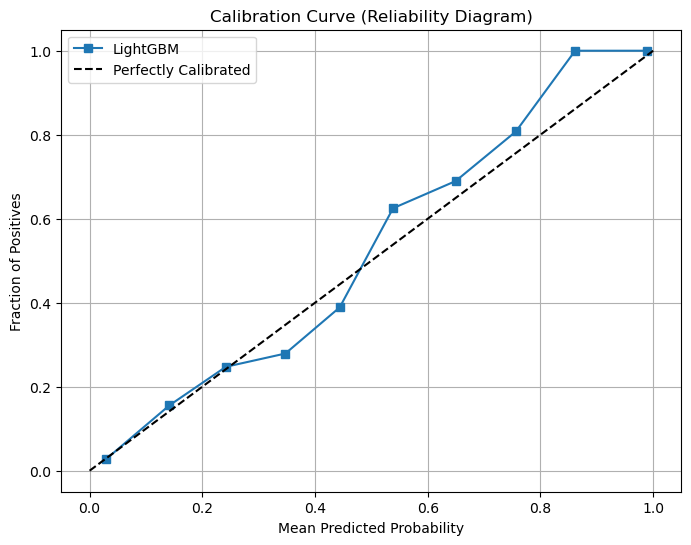

In [64]:
pred_probs_lgb = lgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1 (default)

# Calculate calibration curve for LightGBM
fraction_of_positives_lgb, mean_predicted_value_lgb = calibration_curve(
    y_test, pred_probs_lgb, n_bins=10
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_lgb, fraction_of_positives_lgb, "s-", label="LightGBM")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")  # Diagonal line

plt.title("Calibration Curve (Reliability Diagram)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.show()



In [65]:
import joblib
joblib.dump(lgb_model, 'best_tree_model.pkl')

['best_tree_model.pkl']

## NN

In [6]:
X = X.values 
y = y.values 

In [67]:
# Define per-fold score containers
pre_per_fold = []
recall_per_fold = []
loss_per_fold = []
history_per_fold = []

# Best model tracking
best_model = None
best_score = 1000
best_fold = 0

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
  scaler = RobustScaler()
  X_training = scaler.fit_transform(X[train])
  X_test = scaler.transform(X[test])
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)
  # Define the model architecture
  model = None
  model= Sequential()
  model.add(Dense(128,activation="relu"))
  model.add(Dense(64,activation="relu"))
  model.add(Dense(32,activation="relu"))
  model.add(Dense(16,activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['precision', 'recall'])


  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model and store the losses per fold during training
  history = model.fit(X_training, y[train], validation_data =[X_test, y[test]],
              batch_size=8,
              epochs=20,
              verbose=1,
              callbacks=[early_stopping])
  history_per_fold.append(history.history['loss'])

  # Generate generalization metrics and evaluate on the k-1 fold
  scores = model.evaluate(X_test, y[test], verbose=1)
  print(f'Score for fold {fold_no}: Loss: {scores[0]:.4f} - precision: {scores[1]:.4f} - Recall: {scores[2]:.4f}')
  
  recall_per_fold.append(scores[2])
  pre_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

print(f'\nBest model from fold {best_fold} with loss: {best_score:.4f}')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.3454 - precision: 0.7615 - recall: 0.5516 - val_loss: 0.2820 - val_precision: 0.8864 - val_recall: 0.6109
Epoch 2/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2782 - precision: 0.8788 - recall: 0.6413 - val_loss: 0.3064 - val_precision: 0.9653 - val_recall: 0.5442
Epoch 3/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2636 - precision: 0.9010 - recall: 0.6624 - val_loss: 0.2822 - val_precision: 0.8923 - val_recall: 0.6543
Epoch 4/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2578 - precision: 0.9145 - recall: 0.6602 - val_loss: 0.2727 - val_precision: 0.9524 - val_recall: 0.6239
Epoch 5/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2579 - precision: 0.9089 - recall: 0.6596 - val_loss: 0.2641 - val_precision: 0.9387 - val_recall: 0.6326
Epoch 6/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

In [68]:
# Provide average scores
print('Score per fold')
for i in range(0, len(pre_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - precision: {pre_per_fold[i]:.4f} - Recall: {recall_per_fold[i]:.4f}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> precision: {np.mean(pre_per_fold):.4f} (+- {np.std(pre_per_fold):.4f})')
print(f'> Recall: {np.mean(recall_per_fold):.4f} (+- {np.std(recall_per_fold):.4f})')
print(f'> Loss: {np.mean(loss_per_fold):.4f}')
print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.2904 - precision: 0.9028 - Recall: 0.6732
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2756 - precision: 0.9155 - Recall: 0.6754
------------------------------------------------------------------------
> Fold 3 - Loss: 0.2985 - precision: 0.9668 - Recall: 0.5478
------------------------------------------------------------------------
> Fold 4 - Loss: 0.2916 - precision: 0.9107 - Recall: 0.6647
------------------------------------------------------------------------
> Fold 5 - Loss: 0.2592 - precision: 0.9145 - Recall: 0.6973
------------------------------------------------------------------------
Average scores for all folds:
> precision: 0.9221 (+- 0.0228)
> Recall: 0.6517 (+- 0.0530)
> Loss: 0.2831
------------------------------------------------------------------------


In [7]:
# Scale the test data using the same scaler from training
scaler = RobustScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define NN architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['precision', 'recall']
)

# Train on full training set, validate on test set
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=8,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20


c:\Users\david\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3164/3164 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.3614 - precision: 0.7728 - recall: 0.4914 - val_loss: 0.2690 - val_precision: 0.8544 - val_recall: 0.6674
Epoch 2/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2805 - precision: 0.8746 - recall: 0.6456 - val_loss: 0.2628 - val_precision: 0.9179 - val_recall: 0.6486
Epoch 3/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2583 - precision: 0.9060 - recall: 0.6738 - val_loss: 0.2536 - val_precision: 0.9500 - val_recall: 0.6333
Epoch 4/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2629 - precision: 0.9179 - recall: 0.6695 - val_loss: 0.2520 - val_precision: 0.9212 - val_recall: 0.6775
Epoch 5/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2531 - precision: 0.9216 - recall: 0.6649 - val_loss: 0.2751 - val_precision: 0.9492 - val_recall: 0.6362
Epoch 6/20
3164/3164 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2601 - precision: 0.9220 - recall: 0.6695 - val_loss: 0.2593 - val_precision: 0.9719 - val_recall

In [10]:
# Predict classes on train set
train_preds = (model.predict(X_train_scaled) > 0.5).astype(int)
train_f1 = f1_score(y_train, train_preds)
print(f"Train F1 score: {train_f1:.4f}")

# Predict classes on test set
predictions = (model.predict(X_test_scaled) > 0.5).astype(int)
test_f1 = f1_score(y_test, predictions)
print(f"Test F1 score: {test_f1:.4f}")

791/791 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step
Train F1 score: 0.7934
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
Test F1 score: 0.7816


Text(70.72222222222221, 0.5, 'Actual')

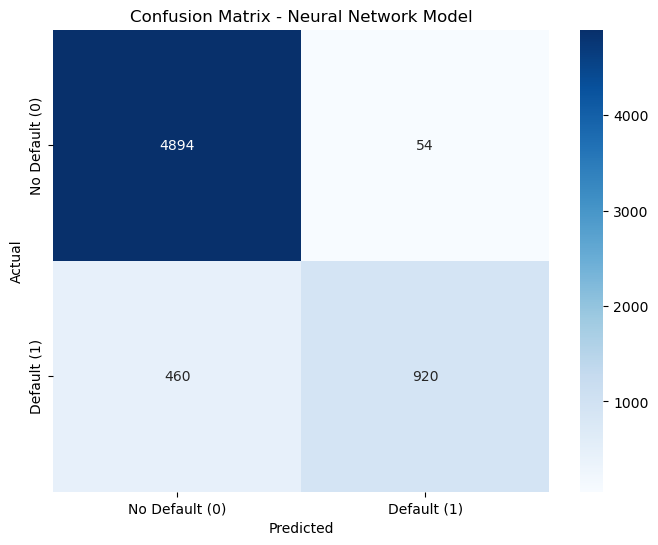

In [11]:
# Create confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title('Confusion Matrix - Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# Save the best model
#model.save('best_nn_model.keras')

In [13]:
best_model = keras.models.load_model('best_nn_model.keras')

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


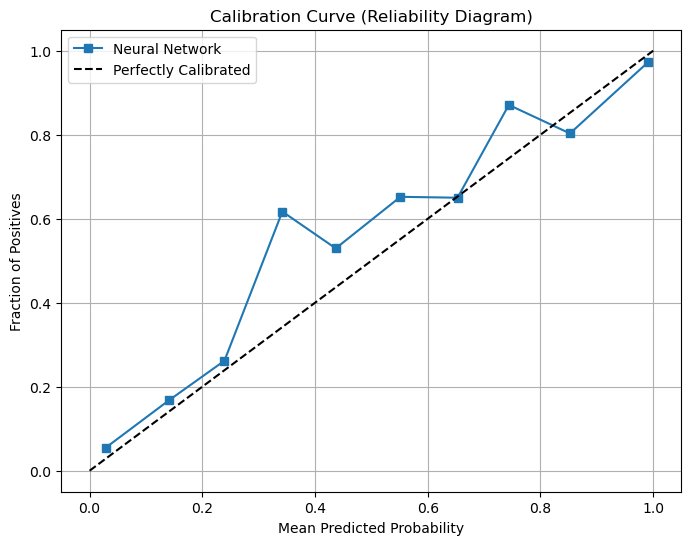

In [14]:
# Make sure we have the correct data format
pred_probs_nn = best_model.predict(X_test_scaled).flatten()

# Calculate calibration curve for Neural Network
fraction_of_positives_nn, mean_predicted_value_nn = calibration_curve(
    y_test, pred_probs_nn, n_bins=10
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_nn, fraction_of_positives_nn, "s-", label="Neural Network")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")  # Diagonal line

plt.title("Calibration Curve (Reliability Diagram)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.show()

### Extras

#### Shap

In [15]:
import shap

In [16]:
# Create a function that returns probabilities (SHAP works better with probabilities)
def model_predict(X):
    return best_model.predict(X).flatten()

# Initialize SHAP explainer with a subset of training data as background
# Using 100 samples for faster computation
background_data = X_train_scaled[:100]
explainer = shap.DeepExplainer(best_model, background_data)

# Calculate SHAP values for a subset of test data (first 100 samples for speed)
test_sample = X_test_scaled[:100]
shap_values = explainer.shap_values(test_sample)
shap_values = shap_values[:, :, 0]
print(f"Shape of SHAP values: {shap_values.shape}")

c:\Users\david\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


Shape of SHAP values: (100, 17)


In [17]:
feature_names = data.drop('loan_status', axis=1).columns.tolist()

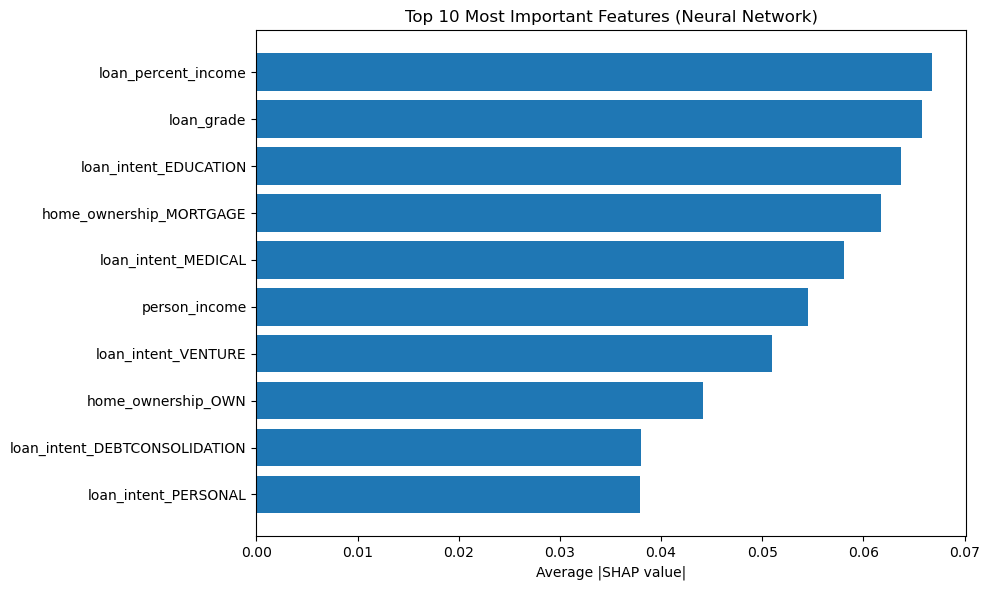

In [18]:
# 3. Feature importance ranking
feature_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)


# Plot top 10 features
plt.figure(figsize=(10, 6))
top_10 = importance_df.head(10)
plt.barh(range(len(top_10)), top_10['importance'])
plt.yticks(range(len(top_10)), top_10['feature'])
plt.xlabel('Average |SHAP value|')
plt.title('Top 10 Most Important Features (Neural Network)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

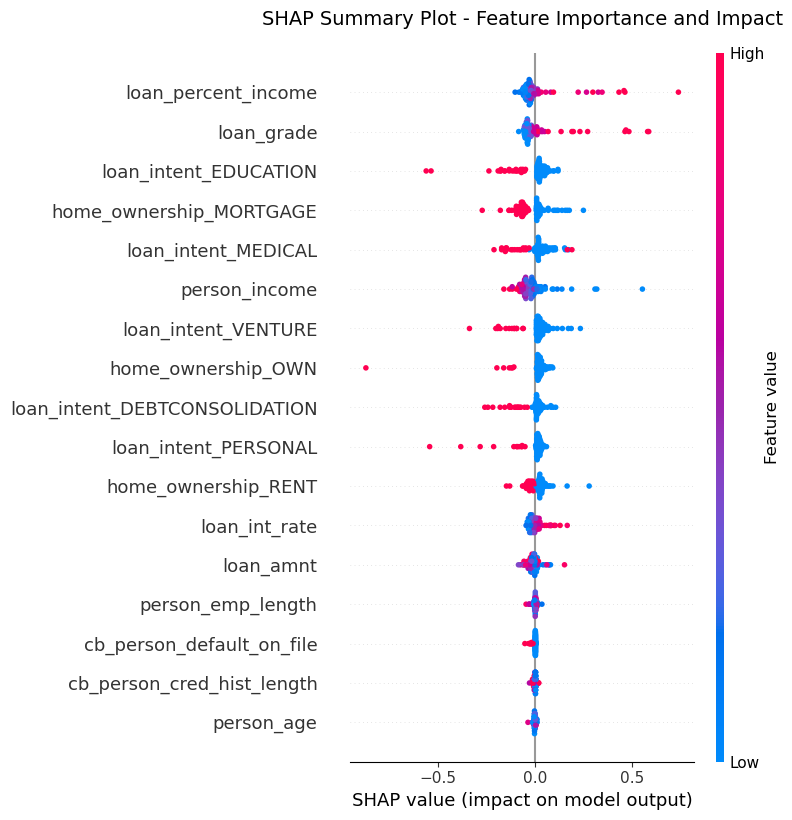

In [19]:
# 1. Summary plot - shows feature importance and impact
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, test_sample, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Feature Importance and Impact', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

A SHAP value close to zero means the feature had little impact on that prediction.

Positive SHAP values push the prediction higher (increase likelihood of the predicted outcome).

Negative SHAP values push the prediction lower (decrease likelihood of the predicted outcome).

#### Lime

In [20]:
import lime
import lime.lime_tabular

In [21]:
# Prepare data for LIME
# We need to use the original DataFrame format for LIME
data_temp = pd.read_csv('final_data.csv')
X_lime = data_temp.drop('loan_status', axis=1)
y_lime = data_temp['loan_status']

# Split the data (same as before)
X_train_lime, X_test_lime, y_train_lime, y_test_lime = train_test_split(
    X_lime, y_lime, test_size=0.2, random_state=22, shuffle=True, stratify=y_lime
)

In [22]:
# Create a wrapper function for the neural network model
def nn_predict_proba(X):
    """
    Wrapper function to make predictions compatible with LIME
    """
    # Scale the input data
    scaler = RobustScaler()  
    X_scaled = scaler.fit_transform(X)
    
    # Get predictions
    probabilities = best_model.predict(X_scaled)
    
    # LIME expects probabilities for both classes
    # prob_class_0 = 1 - probabilities, prob_class_1 = probabilities
    prob_both_classes = np.column_stack([1 - probabilities.flatten(), probabilities.flatten()])
    
    return prob_both_classes


In [23]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_lime.values,  # Training data
    feature_names=X_train_lime.columns.tolist(),  # Feature names
    class_names=['No Default', 'Default'],  # Class names
    mode='classification',  # Classification mode
    discretize_continuous=True,  # Discretize continuous features
    random_state=42
)

print("LIME explainer initialized successfully!")

LIME explainer initialized successfully!


In [24]:
# Select interesting observations to explain
predictions_lime = nn_predict_proba(X_test_lime.values)
probabilities = predictions_lime[:, 1]  # Probability of default

# Select 4 random observations for LIME analysis
np.random.seed(11)  # For reproducibility
random_indices = np.random.choice(len(X_test_lime), 4, replace=False)

print("Selected random observations for LIME analysis:")
for i, idx in enumerate(random_indices):
    print(f"Observation {i+1} (idx {idx}): Probability of default = {probabilities[idx]:.4f}")


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
Selected random observations for LIME analysis:
Observation 1 (idx 845): Probability of default = 0.0459
Observation 2 (idx 1926): Probability of default = 0.0872
Observation 3 (idx 2418): Probability of default = 0.0004
Observation 4 (idx 4851): Probability of default = 0.1835


LIME ANALYSIS - 4 RANDOM OBSERVATIONS

--------------------------------------------------
OBSERVATION 1 (Index: 845)
Predicted Probability of Default: 0.0459
--------------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


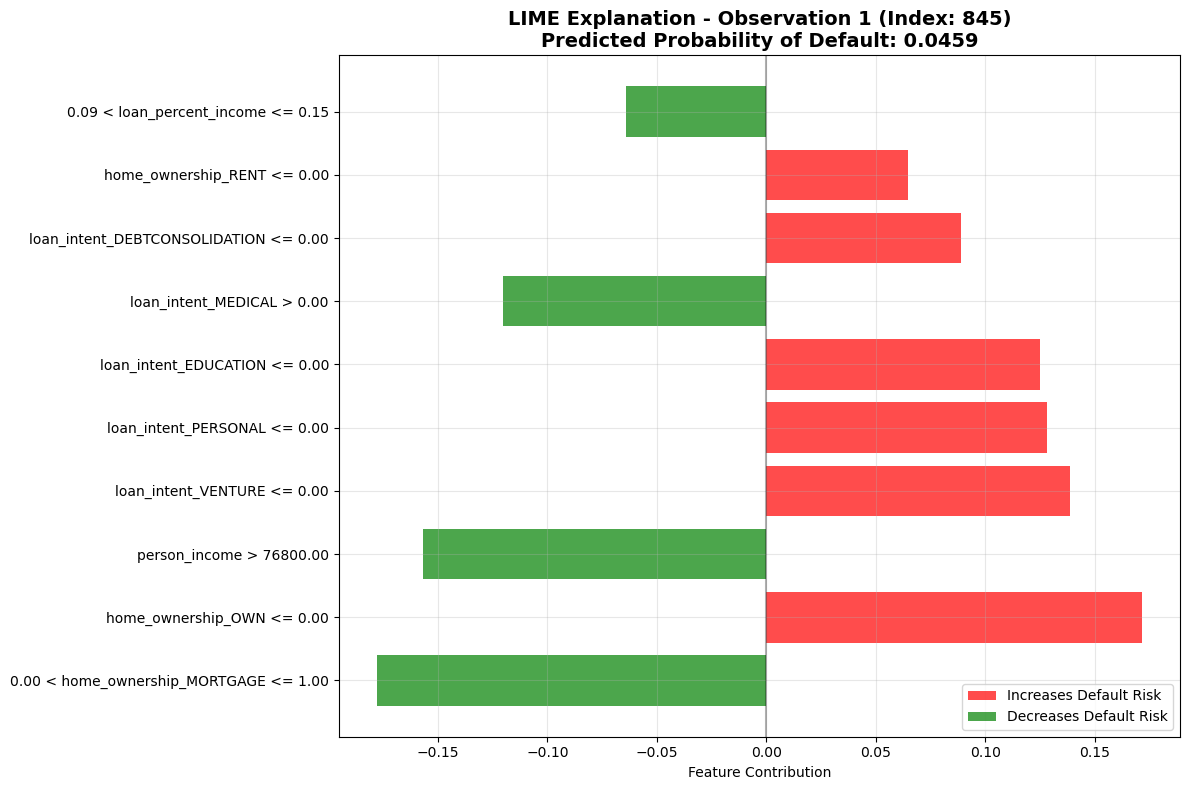


--------------------------------------------------
OBSERVATION 2 (Index: 1926)
Predicted Probability of Default: 0.0872
--------------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


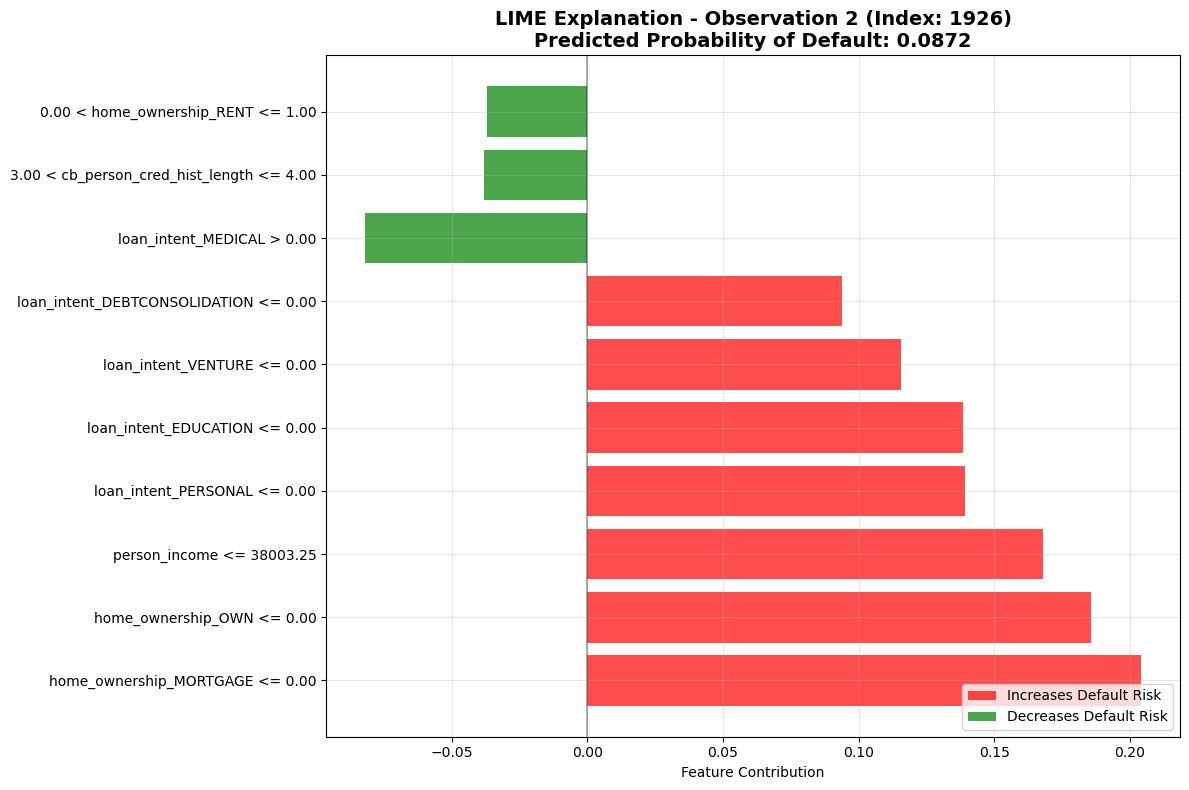


--------------------------------------------------
OBSERVATION 3 (Index: 2418)
Predicted Probability of Default: 0.0004
--------------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


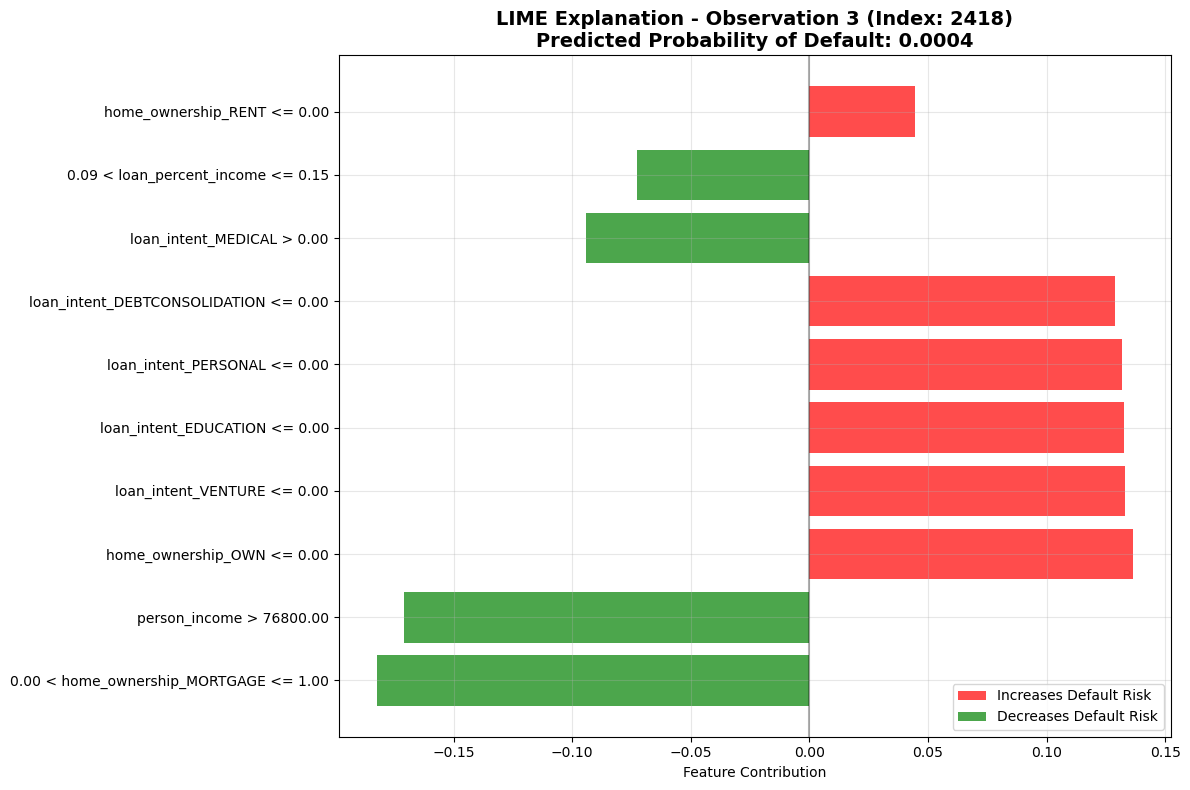


--------------------------------------------------
OBSERVATION 4 (Index: 4851)
Predicted Probability of Default: 0.1835
--------------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


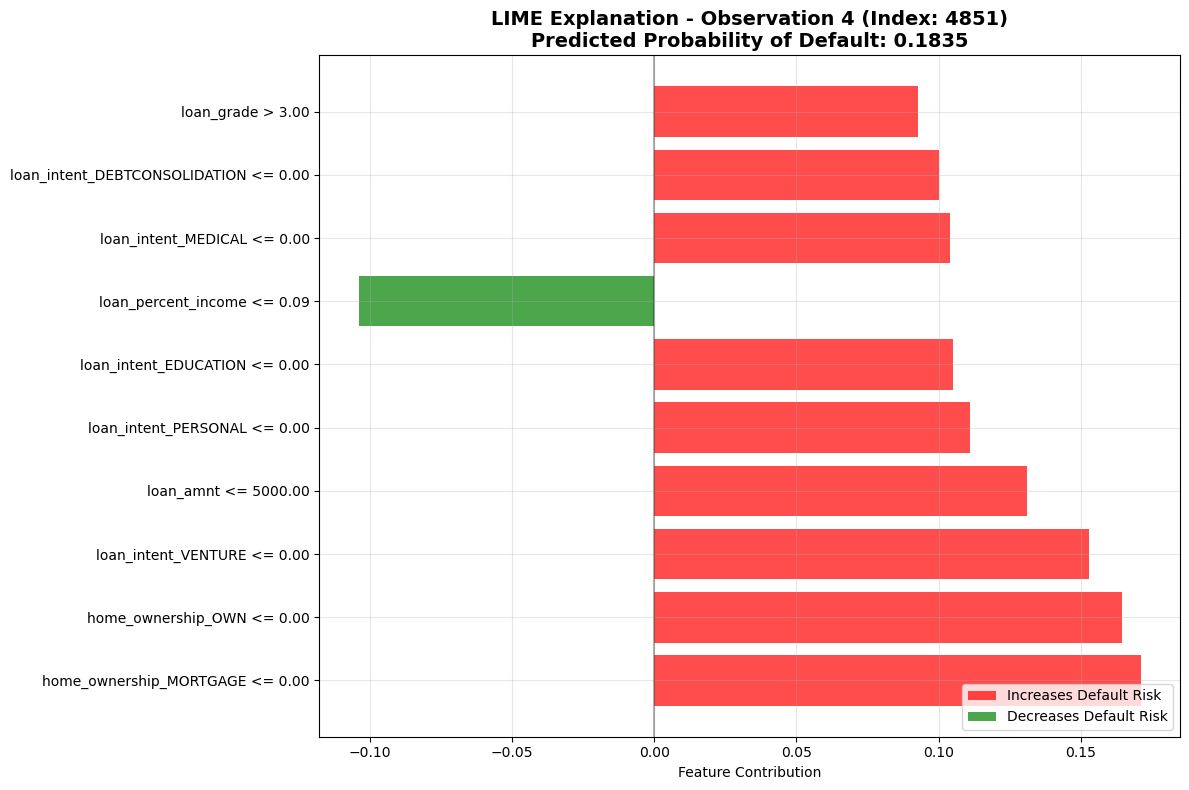

In [25]:
# LIME explanation for 4 random observations
print("="*80)
print("LIME ANALYSIS - 4 RANDOM OBSERVATIONS")
print("="*80)

explanations = []

for i, idx in enumerate(random_indices):
    print(f"\n{'-'*50}")
    print(f"OBSERVATION {i+1} (Index: {idx})")
    print(f"Predicted Probability of Default: {probabilities[idx]:.4f}")
    print(f"{'-'*50}")
    
    # Generate explanation
    explanation = explainer.explain_instance(
        X_test_lime.iloc[idx].values,  # Instance to explain
        nn_predict_proba,  # Prediction function
        num_features=10,  # Number of features to show
        num_samples=1000  # Number of samples for local approximation
    )
    
    explanations.append(explanation)
    
    # Create individual plot for this explanation
    plt.figure(figsize=(12, 8))
    
    # Get the explanation as matplotlib figure
    exp_list = explanation.as_list()
    features = [item[0] for item in exp_list]
    contributions = [item[1] for item in exp_list]
    
    # Create horizontal bar plot
    colors = ['red' if x > 0 else 'green' for x in contributions]
    y_pos = np.arange(len(features))
    
    plt.barh(y_pos, contributions, color=colors, alpha=0.7)
    plt.yticks(y_pos, features)
    plt.xlabel('Feature Contribution')
    plt.title(f'LIME Explanation - Observation {i+1} (Index: {idx})\nPredicted Probability of Default: {probabilities[idx]:.4f}', 
              fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.7, label='Increases Default Risk'),
                      Patch(facecolor='green', alpha=0.7, label='Decreases Default Risk')]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()

In [26]:
# Detailed analysis table
print("\n" + "="*80)
print("DETAILED ANALYSIS SUMMARY")
print("="*80)

for i, (idx, explanation) in enumerate(zip(random_indices, explanations)):
    print(f"\nObservation {i+1} (Index: {idx})")
    print(f"Predicted Probability: {probabilities[idx]:.4f}")
    print(f"Prediction: {'DEFAULT' if probabilities[idx] > 0.5 else 'NO DEFAULT'}")
    print("-" * 50)
    
    print("Feature Contributions:")
    for j, (feature, contribution) in enumerate(explanation.as_list()[:8]):
        direction = "↑" if contribution > 0 else "↓"
        print(f"  {j+1:2d}. {feature:<35} {contribution:+7.4f} {direction}")


DETAILED ANALYSIS SUMMARY

Observation 1 (Index: 845)
Predicted Probability: 0.0459
Prediction: NO DEFAULT
--------------------------------------------------
Feature Contributions:
   1. 0.00 < home_ownership_MORTGAGE <= 1.00 -0.1778 ↓
   2. home_ownership_OWN <= 0.00          +0.1714 ↑
   3. person_income > 76800.00            -0.1569 ↓
   4. loan_intent_VENTURE <= 0.00         +0.1385 ↑
   5. loan_intent_PERSONAL <= 0.00        +0.1281 ↑
   6. loan_intent_EDUCATION <= 0.00       +0.1249 ↑
   7. loan_intent_MEDICAL > 0.00          -0.1201 ↓
   8. loan_intent_DEBTCONSOLIDATION <= 0.00 +0.0887 ↑

Observation 2 (Index: 1926)
Predicted Probability: 0.0872
Prediction: NO DEFAULT
--------------------------------------------------
Feature Contributions:
   1. home_ownership_MORTGAGE <= 0.00     +0.2041 ↑
   2. home_ownership_OWN <= 0.00          +0.1855 ↑
   3. person_income <= 38003.25           +0.1678 ↑
   4. loan_intent_PERSONAL <= 0.00        +0.1391 ↑
   5. loan_intent_EDUCATION <= 0.

## Best model

In [35]:
best_tree_model = joblib.load('best_tree_model.pkl')

In [ ]:
# Get predictions from the fitted LightGBM model
pred_probs_lgb = best_tree_model.predict_proba(X_test)[:, 1]

# Create a dataframe with predictions, true labels, and loan amounts
test_pred_df = pd.DataFrame({
    'prob_default': pred_probs_lgb,
    'true_loan_status': y_test,
    'loan_amnt': X_test['loan_amnt'].values  # Add loan amount for calculations
})

test_pred_df['Total Expected Losses'] = test_pred_df['prob_default'] * test_pred_df['loan_amnt'] * 0.6

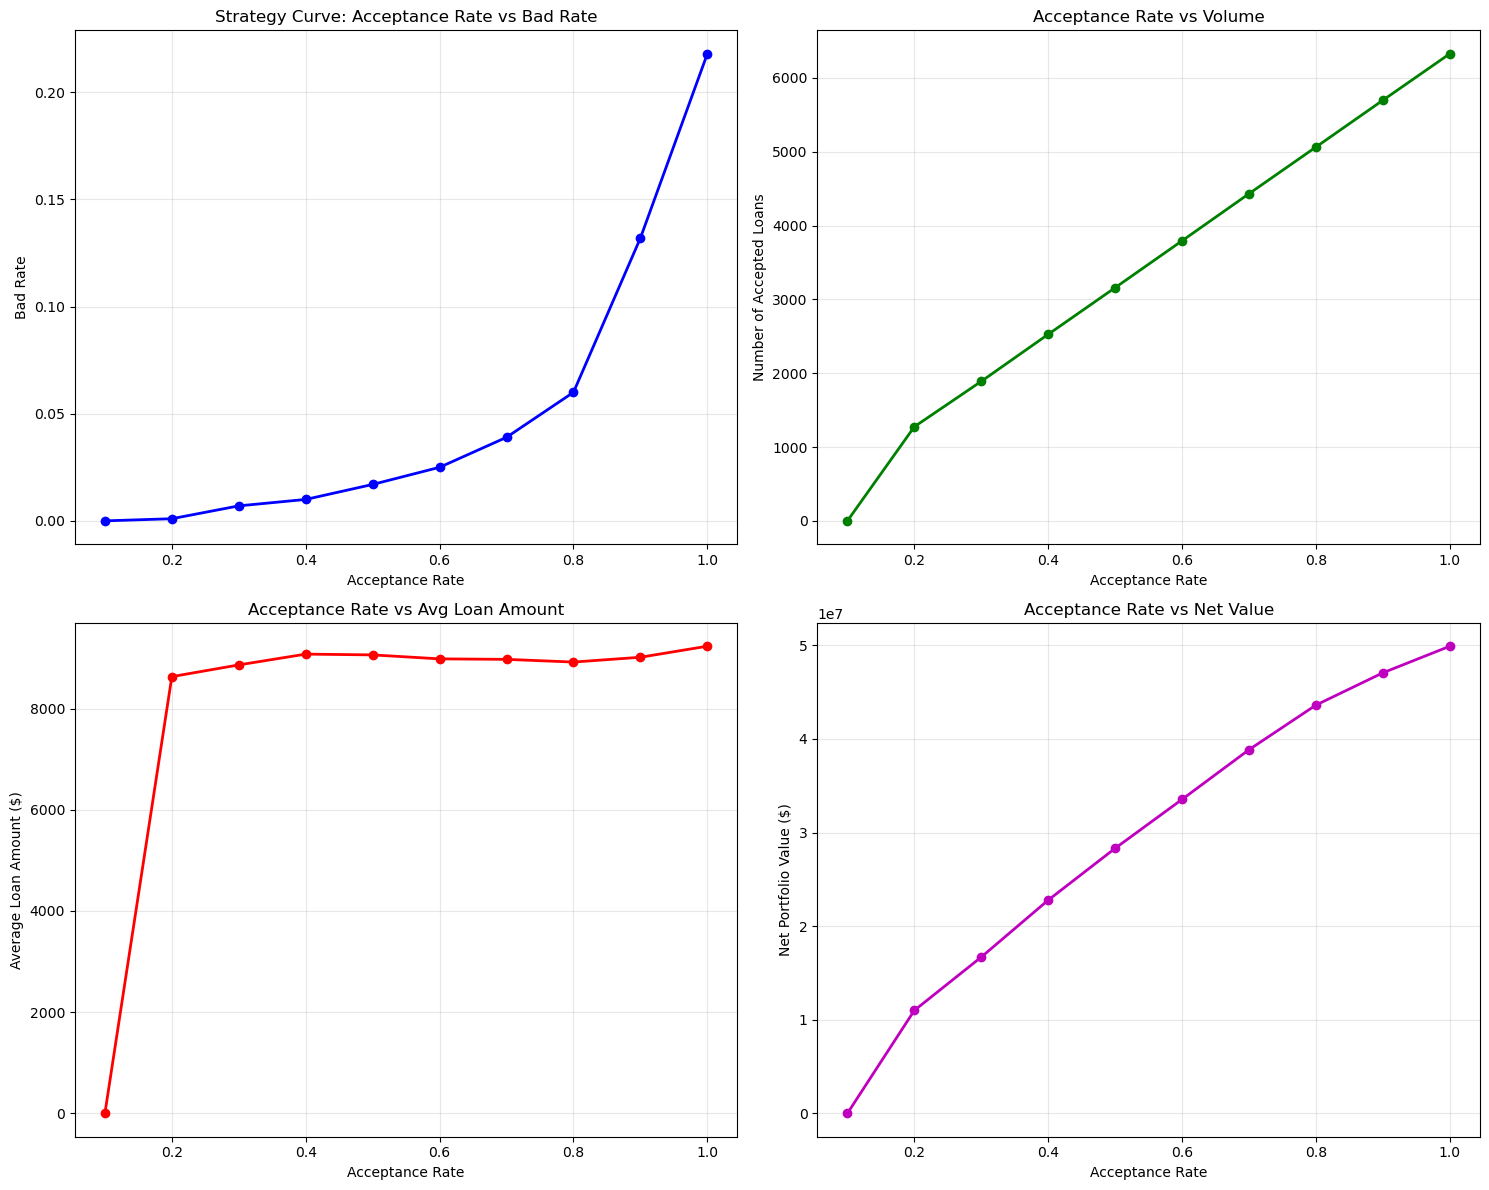

In [73]:
# Define acceptance rates to test
accept_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Initialize lists to store results
thresholds = []
bad_rates = []
num_accepted = []
avg_loan_amt = []
estimated_value = []
total_expected_loss = []  # This should remain a list

# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(test_pred_df['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(thresh)
    
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    
    # Calculate metrics
    if len(accepted_loans) > 0:
        # Bad rate
        bad_rate = np.sum(accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])
        bad_rates.append(round(bad_rate, 3))
        
        # Number of accepted loans
        num_accepted.append(len(accepted_loans))
        
        # Average loan amount
        avg_loan_amt.append(round(accepted_loans['loan_amnt'].mean(), 2))
        
        # Estimated value (total loan amount - estimated losses)
        total_loan_value = accepted_loans['loan_amnt'].sum()
        estimated_losses = bad_rate * total_loan_value
        est_value = total_loan_value - estimated_losses
        
        # Calculate total expected loss for accepted loans and append to list
        total_exp_loss_accepted = accepted_loans['Total Expected Losses'].sum()
        total_expected_loss.append(round(total_exp_loss_accepted, 2))
        
        estimated_value.append(round(est_value, 2))
        
    else:
        bad_rates.append(0.0)
        num_accepted.append(0)
        avg_loan_amt.append(0.0)
        estimated_value.append(0.0)
        total_expected_loss.append(0.0)  # Add 0 for consistency

# Create a data frame of the enhanced strategy table
strat_df = pd.DataFrame({
    'Acceptance Rate': accept_rates,
    'Threshold': thresholds,
    'Bad Rate': bad_rates,
    'Num Accepted': num_accepted,
    'Avg Loan Amt': avg_loan_amt,
    'Estimated Value': estimated_value,
    'Total Expected Loss': total_expected_loss
})



# Calculate additional business metrics
strat_df['Total Portfolio Value'] = np.round(strat_df['Num Accepted'] * strat_df['Avg Loan Amt'],2)
strat_df['Net Value'] = np.round(strat_df['Total Portfolio Value'] - strat_df['Total Expected Loss'],2)



# Plot multiple metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Acceptance Rate vs Bad Rate
ax1.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'], 'bo-', linewidth=2, markersize=6)
ax1.set_xlabel('Acceptance Rate')
ax1.set_ylabel('Bad Rate')
ax1.set_title('Strategy Curve: Acceptance Rate vs Bad Rate')
ax1.grid(True, alpha=0.3)

# Plot 2: Acceptance Rate vs Number of Accepted Loans
ax2.plot(strat_df['Acceptance Rate'], strat_df['Num Accepted'], 'go-', linewidth=2, markersize=6)
ax2.set_xlabel('Acceptance Rate')
ax2.set_ylabel('Number of Accepted Loans')
ax2.set_title('Acceptance Rate vs Volume')
ax2.grid(True, alpha=0.3)

# Plot 3: Acceptance Rate vs Average Loan Amount
ax3.plot(strat_df['Acceptance Rate'], strat_df['Avg Loan Amt'], 'ro-', linewidth=2, markersize=6)
ax3.set_xlabel('Acceptance Rate')
ax3.set_ylabel('Average Loan Amount ($)')
ax3.set_title('Acceptance Rate vs Avg Loan Amount')
ax3.grid(True, alpha=0.3)

# Plot 4: Acceptance Rate vs Net Value
ax4.plot(strat_df['Acceptance Rate'], strat_df['Net Value'], 'mo-', linewidth=2, markersize=6)
ax4.set_xlabel('Acceptance Rate')
ax4.set_ylabel('Net Portfolio Value ($)')
ax4.set_title('Acceptance Rate vs Net Value')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal acceptance rate (highest net value)
optimal_idx = strat_df['Net Value'].idxmax()
optimal_rate = strat_df.loc[optimal_idx]


In [74]:
strat_df.head(10)

,Acceptance Rate,Threshold,Bad Rate,Num Accepted,Avg Loan Amt,Estimated Value,Total Expected Loss,Total Portfolio Value,Net Value
0,0.1,0.000,0.000,0,0.00,0.00,0.00,0.00,0.00
1,0.2,0.007,0.001,1275,8632.04,10997217.96,7331.27,11005851.00,10998519.73
2,0.3,0.020,0.007,1890,8863.69,16628283.33,54530.42,16752374.10,16697843.68
3,0.4,0.035,0.010,2527,9076.90,22710402.51,154634.98,22937326.30,22782691.32
4,0.5,0.056,0.017,3159,9061.45,28144868.08,306601.40,28625120.55,28318519.15
5,0.6,0.087,0.025,3794,8983.08,33237390.62,537100.09,34081805.52,33544705.43
6,0.7,0.141,0.039,4432,8973.29,38199299.10,915997.28,39769621.28,38853624.00
7,0.8,0.290,0.060,5064,8919.98,42468021.28,1551649.72,45170778.72,43619129.00
8,0.9,0.990,0.132,5698,9015.05,44606484.85,4300472.11,51367754.90,47067282.79
9,1.0,1.000,0.218,6328,9233.57,45687680.15,8522778.13,58430030.96,49907252.83


Total Expected Loss=PD×EAD×LGD 

PD (Probability of Default)  

EAD (Exposure at Default)  The amount of money exposed to loss at the time of default. (money we borrowed and lost it) in this case loan amt


LGD (Loss Given Default)
The proportion of the EAD that is lost after accounting for recoveries (e.g., collateral).
Example: If 40% of the exposure is recovered, LGD = 0.6.

In [77]:
test_pred_df.head(2)
tot_exp_loss= round(test_pred_df['Total Expected Losses'].sum(),2)

Total expected loss:  $8,522,778.13

Expected Loss Statistics:
Mean expected loss per loan: $1346.84
Median expected loss per loan: $233.76
Max expected loss per loan: $16790.72
Total portfolio value: $58,430,000.00
Expected loss rate: 14.59%


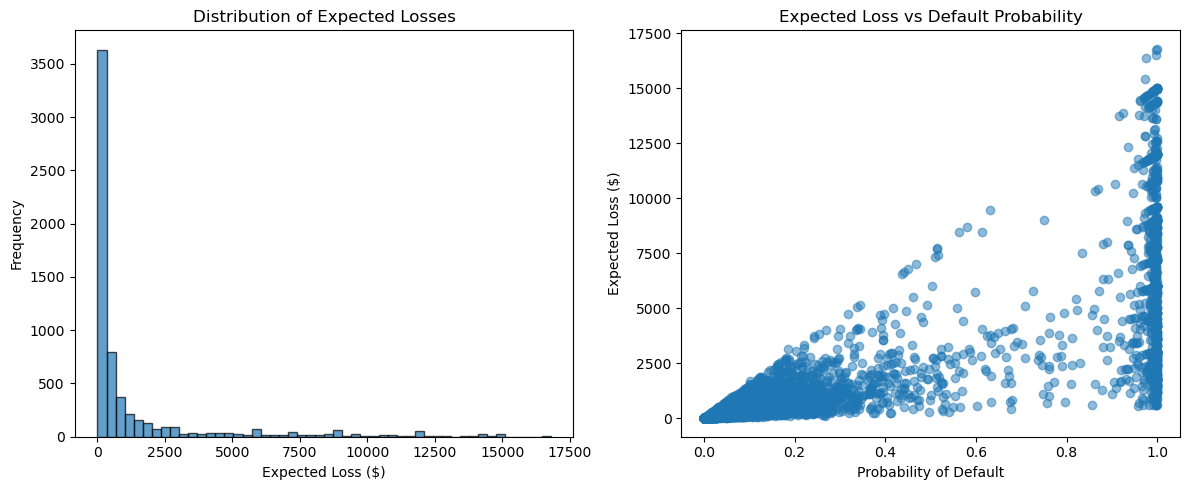

In [78]:
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

# Additional statistics
print(f"\nExpected Loss Statistics:")
print(f"Mean expected loss per loan: ${test_pred_df['Total Expected Losses'].mean():.2f}")
print(f"Median expected loss per loan: ${test_pred_df['Total Expected Losses'].median():.2f}")
print(f"Max expected loss per loan: ${test_pred_df['Total Expected Losses'].max():.2f}")
print(f"Total portfolio value: ${test_pred_df['loan_amnt'].sum():,.2f}")
print(f"Expected loss rate: {(tot_exp_loss / test_pred_df['loan_amnt'].sum()) * 100:.2f}%")

# Show distribution of expected losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_pred_df['Total Expected Losses'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Expected Loss ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Losses')

plt.subplot(1, 2, 2)
plt.scatter(test_pred_df['prob_default'], test_pred_df['Total Expected Losses'], alpha=0.5)
plt.xlabel('Probability of Default')
plt.ylabel('Expected Loss ($)')
plt.title('Expected Loss vs Default Probability')

plt.tight_layout()
plt.show()